In [1]:
import os
from os import listdir
from os.path import isfile, isdir, join, getsize

import pandas as pd
import re
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from mpl_toolkits.mplot3d import Axes3D


In [4]:
db_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'logs')
db_log_dir

'../data/exp_logs-parallelizaton_exp/logs'

In [5]:
isdir(db_log_dir)

True

In [6]:
all_files = listdir(db_log_dir)

In [7]:
interesting_log_files = [x for x in listdir(db_log_dir) if getsize(join(db_log_dir, x)) > 0]

In [8]:
interesting_log_files

['DyLDO-core-type-parallel_2-test-2_batch_11.log',
 'DyLDO-core-attribute-parallel_8-test-2_batch_22.log',
 'DyLDO-core-type-parallel_4-test-2_batch_17.log',
 'DyLDO-core-type-parallel_2-test-2_batch_38.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_4.log',
 'DyLDO-core-attribute-parallel_4-test-2_batch_40.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_25.log',
 'DyLDO-core-type-parallel_8-test-2_batch_12.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_2.log',
 'DyLDO-core-type-parallel_4-test-2_batch_31.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_18.log',
 'DyLDO-core-type-parallel_4-test-2_batch_2.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_16.log',
 'DyLDO-core-type-parallel_2-test-2_batch_14.log',
 'DyLDO-core-attribute-parallel_2-test-2_batch_36.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_27.log',
 'DyLDO-core-attribute-parallel_2-test-2_batch_25.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_31.log',
 'DyLDO-core-type-paral

In [9]:
stats = {}

df = pd.DataFrame(columns=['Dataset', 'Version', 'Model', 'Cores', 'Conflicts'])
for file in interesting_log_files:
    # DyLDO-core-attribute-parallel_16-test-2_batch_43
    z = re.match('(.*)(-.*)(-parallel)(_[0-9]+)(-test-[0-9])(_batch)?_([0-9]+)$', file.replace('.log', ''))
    # ('DyLDO-core', '-attribute', '-parallel', '_16', '-test-2', '_batch', '43')
    if len(z.groups()) != 7:
        display(z.groups())
        print(file)
    stats[file.replace('.log', '')] = {}
    conflicts = 0
    with open(join(db_log_dir, file), 'r') as log_file:
        lines = log_file.readlines()
        for line in lines:
            vs_id = line.split('[UPDATES]')[-1].replace('\n', '').strip()
            if vs_id in stats[file.replace('.log', '')]:
                stats[file.replace('.log', '')][vs_id] += 1
            else:
                stats[file.replace('.log', '')][vs_id] = 1
            conflicts += 1
        df = df.append({'Dataset': z.groups()[0], 
                        'Version': z.groups()[6], 
                        'Model': z.groups()[1][1::], 
                        'Cores': z.groups()[3][1::], 
                        'Conflicts': conflicts },ignore_index=True)

df['Cores'] = df['Cores'].astype('int')    

In [10]:
def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    #print(np.min(values[0]))
    """
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    #print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    #display(temp)
    lvls, colors = zip(*temp)
    #display(lvls)
    #display(colors)
    
    # TODO: 40 is not displayed properly
    if lvls[2] == 40:
        lvls = list(lvls)
        lvls[2] = 39
    #lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)
    """
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.view_init(35, 40)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    #ax.set_ylim([-y_offset, len(y)+y_offset])
    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Merge Conflicts", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight', dpi=300)
        
    plt.show()


In [190]:
asd = df[df['Model'] == 'attribute']
asd[asd['Cores'] == 16]

,Dataset,Version,Model,Cores,Conflicts
Version,,,,,
0,DyLDO-core,0,attribute,16,586
1,DyLDO-core,1,attribute,16,580
2,DyLDO-core,2,attribute,16,569
3,DyLDO-core,3,attribute,16,606
4,DyLDO-core,4,attribute,16,614
5,DyLDO-core,5,attribute,16,628
6,DyLDO-core,6,attribute,16,530
7,DyLDO-core,7,attribute,16,559
8,DyLDO-core,8,attribute,16,619


2


array([16, 24, 13, 20, 52, 9, 20, 17, 30, 32, 22, 47, 26, 28, 20, 18, 24,
       15, 21, 20, 27, 15, 45, 31, 20, 54, 97, 17, 60, 53, 33, 29, 22, 36,
       85, 39, 48, 30, 16, 22, 16, 16, 22, 58, 13, 24, 27, 25, 28, 17],
      dtype=object)

4


array([117, 94, 94, 110, 115, 99, 89, 78, 95, 125, 153, 127, 142, 117,
       124, 100, 107, 107, 111, 90, 151, 127, 144, 148, 132, 219, 213,
       214, 215, 204, 253, 217, 235, 230, 244, 223, 232, 196, 171, 163,
       165, 147, 161, 171, 117, 133, 126, 129, 139, 118], dtype=object)

8


array([311, 341, 336, 330, 354, 297, 265, 259, 291, 370, 419, 430, 366,
       393, 346, 296, 276, 277, 310, 250, 373, 322, 435, 412, 412, 638,
       607, 571, 581, 671, 640, 602, 568, 603, 590, 580, 606, 522, 480,
       458, 477, 405, 527, 449, 350, 350, 333, 346, 331, 354],
      dtype=object)

16


array([586, 580, 569, 606, 614, 628, 530, 559, 619, 793, 832, 783, 805,
       711, 778, 703, 587, 616, 543, 451, 697, 468, 961, 623, 642, 912,
       965, 940, 1343, 871, 911, 998, 954, 784, 770, 794, 804, 850, 1125,
       847, 762, 599, 1233, 704, 476, 552, 612, 656, 764, 707],
      dtype=object)

50

(4, 50)

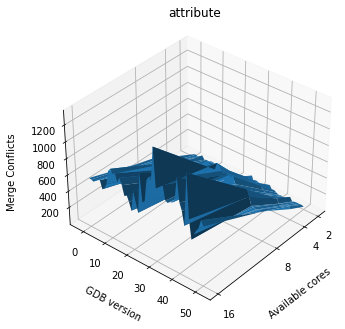

In [185]:
cores = 2
a_frame = df #df[df['Cores'] == cores]
a_frame.index = a_frame['Version']
plot_frame = pd.DataFrame(columns=df['Model'].unique())
for model in df['Model'].unique():
    a_frame = df[df['Model'] == model]
    x = list(a_frame['Cores'].unique())
    #display(len(x))
    values = []
    for core in x:
        print(core)
        values.append(np.array(a_frame[a_frame['Cores'] == core]['Conflicts'].astype(int)))
        display(np.array(a_frame[a_frame['Cores'] == core]['Conflicts']))
    y = list(set(a_frame['Version'].astype(int)))
    display(len(y))
    display(np.array(values).shape)
    #values = np.array(df[['Cores', 'Conflicts']])
    my_3d_plot(x, y, values, model, z_lim=None, save_dir=None)
    break
    #TODO wait until more type data is there
    

Text(0.5, 1.0, 'type')

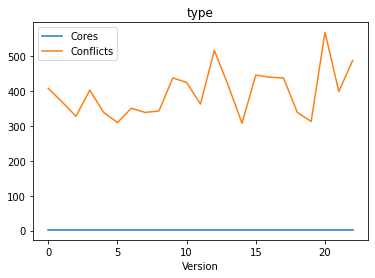

In [175]:
a_frame = df[df['Cores'] == 2]
ax = a_frame[a_frame['Model'] == 'type'].plot()
ax.set_title('type')

<AxesSubplot:>

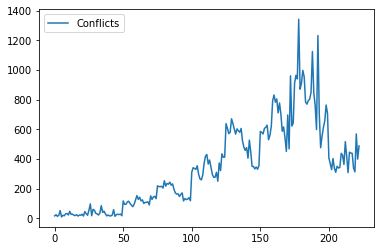

In [97]:

df.plot()

In [11]:
import re
asd = 'DyLDO-core-attribute-parallel_2-test-2_batch_0'

z = re.match('(.*)(-.*)(-parallel)(_[0-9]+)(-test-[0-9])(_batch)?_([0-9]+)$', asd)
z

<re.Match object; span=(0, 46), match='DyLDO-core-attribute-parallel_2-test-2_batch_0'>

In [12]:
z.groups()

('DyLDO-core', '-attribute', '-parallel', '_2', '-test-2', '_batch', '0')

In [13]:
z.groups()[1][1::]

'attribute'

In [14]:
# hot vertex summaries

display(stats)

{'DyLDO-core-type-parallel_2-test-2_batch_11': {'48': 360,
  '-2030505161': 2,
  '564491453': 1},
 'DyLDO-core-attribute-parallel_8-test-2_batch_22': {'-121913705': 16,
  '1383854819': 45,
  '-237374872': 39,
  '1535074497': 1,
  '1609285120': 2,
  '1109828132': 1,
  '1833646158': 5,
  '271392804': 13,
  '1413160744': 1,
  '1072875714': 1,
  '-1805512467': 42,
  '377543283': 3,
  '-212013139': 5,
  '1487371367': 1,
  '681013538': 3,
  '987914379': 1,
  '323493703': 1,
  '-1215354179': 4,
  '-1088303476': 24,
  '-1803393042': 5,
  '84571989': 3,
  '-2136415111': 1,
  '-909850869': 2,
  '-1040226662': 1,
  '1867149505': 2,
  '-442605031': 29,
  '937215393': 4,
  '941249740': 37,
  '1484281741': 2,
  '1206177804': 5,
  '-1293342406': 3,
  '1808603445': 3,
  '-1967559901': 5,
  '1747481197': 4,
  '-1436040256': 1,
  '-1147901181': 1,
  '561771513': 2,
  '-83855854': 1,
  '-1645511108': 2,
  '1838434056': 1},
 'DyLDO-core-type-parallel_4-test-2_batch_17': {'48': 1119,
  '1205067464': 2,
  '

In [ ]:
vs_frame = pd.DataFrame(columns=[''])